In [1]:
#import
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib as mlt
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import Dataset

In [2]:
def data_loading(data_dir):
    data, labels, ids= [], [], []
    df = pd.read_csv(data_dir)
    data_list = df.loc[:,'discourse_text'].values
    label_list_ = df.loc[:,'discourse_type'].values
    id_list = df.loc[:,'id'].values
    type_dict = {'Lead':1,'Position':2,'Claim':3,'Counterclaim':4,'Rebuttal':5,'Evidence':6,'Concluding Statement':7}
    label_list = []
    for i in label_list_:
        label_list.append(type_dict[i])
    if len(data_list)!=len(label_list):
        return 'length bug'
    n = len(data_list)
    for data_ in range(n):
        sentence_split = data_list[data_].split(".")[:-1] if data_list[data_].split('.')[-1] == str('') else data_list[data_].split(".")
        label_split = [label_list[data_] for i in range(len(sentence_split))]
        id_split = [id_list[data_] for i in range(len(sentence_split))]
        for j in range(len(sentence_split)):
            if sentence_split[j]!=' ':
                data.append(sentence_split[j].lower()) 
                labels.append(label_split[j])
                ids.append(id_split[j])
    data_article, labels_article = [],[]
    data_sentence, labels_sentence = [],[]
    for i in range(len(ids)-1):
        if ids[i]==ids[i+1]: 
            data_sentence.append(data[i])
            labels_sentence.append(labels[i])
        else:
            data_article.append(data_sentence)
            labels_article.append(labels_sentence)
            data_sentence,labels_sentence = [],[]
    return data_article , labels_article


train_data = data_loading('./train.csv')
print('训练集数目：', len(train_data[0]))
#print(train_data[0][0],train_data[1][0])

训练集数目： 15593


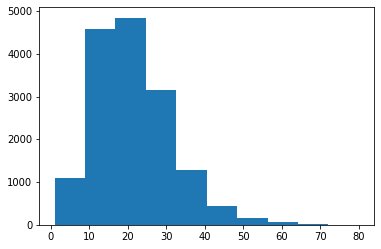

In [3]:
plt.hist([len(train_data[1][i]) for i in range(len(train_data[1]))],bins = 10,rwidth=1, range=(1,80))
plt.show()

In [4]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [5]:
article,labels_ = train_data[0],train_data[1]

In [6]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_art = []
attention_masks_art = []
labels = []
# For every sentence...
for art in range(len(article)):
    input_ids_sent = []
    attention_masks_sent = []
    for sent in article[art]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 32,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids_sent.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_sent.append(encoded_dict['attention_mask'])



    input_ids_sent = torch.cat(input_ids_sent, dim=0)
    attention_masks_sent = torch.cat(attention_masks_sent, dim=0)
    labels_sent = torch.tensor(labels_[art])

    input_ids_art.append(input_ids_sent)
    attention_masks_art.append(attention_masks_sent)
    labels.append(labels_sent)

#labels = [label.tolist() for label in labels]

#print('Original: ', article[0])
print('Token IDs:', input_ids_art[:2],labels[:2])
print(attention_masks_art[:2])
print(labels[2:4])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Token IDs: [tensor([[  101,  2715,  4286,  2651,  2024,  2467,  2006,  2037,  3042,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2024,  2467,  2006,  2037,  3042,  2062,  2084,  1019,
          2847,  1037,  2154,  2053,  2644,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2035,  2027,  2079,  2003,  3793,  2067,  1998,  2830,  1998,
          2074,  2031,  2177, 11834,  2015,  2006,  2591,  2865,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2130,  2079,  2009,  2096,  4439,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,    

In [7]:
#对文章层面进行padding，并记录文章有效句子个数
def padding(id,mask,label,max_sent_num=50,max_sent_len=32):     #确保输入的lst为list列表结构，其中每一个元素为pytorchtensor。max_sent_len需要与前面tokenizer里参数对应上
    valid_num = []
    for i in range(len(id)):
        id[i] = id[i].tolist()
        mask[i] = mask[i].tolist()
        label[i] = label[i].tolist()
        valid_num.append(len(id[i]) if len(id[i])<=50 else 50)
        if len(id[i])<max_sent_num:
            id[i] = id[i]+[[101,102]+[0 for _ in range(max_sent_len-2)] for __ in range(max_sent_num-len(id[i]))]
            mask[i] = mask[i]+[[1,1]+[0 for _ in range(max_sent_len-2)] for __ in range(max_sent_num-len(mask[i]))]
            label[i] = label[i] + [0 for _ in range(max_sent_num-len(label[i]))]
        if len(id[i])>max_sent_num:
            id[i] = id[i][:20]+id[i][-30:]
            mask[i] = mask[i][:20]+id[i][-30:]
            label[i] = label[i][:20]+label[i][-30:]
    #return id,mask,valid_num
    return torch.tensor(id),torch.tensor(mask),torch.tensor(label),valid_num

In [8]:
input_ids_art,attention_masks_art,labels,valid_num = padding(input_ids_art,attention_masks_art,labels)

In [9]:
input_ids_art.size(),attention_masks_art.size(),labels.size(),len(valid_num)

(torch.Size([15593, 50, 32]),
 torch.Size([15593, 50, 32]),
 torch.Size([15593, 50]),
 15593)

In [10]:
class article_dataset(Dataset):
    def __init__(self,input,masks,labels,valid_num):
        super(article_dataset,self).__init__()
        self.input = input
        self.labels = labels
        self.masks = masks
        self.valid_num = valid_num
    def __getitem__(self,idx):
        return self.input[idx],self.masks[idx],self.labels[idx],self.valid_num[idx]      #input和masks维度为sentence_num,sentence_len，label维度 sentence_num
    def __len__(self):                                                                 #valid_num为int
        return len(self.input)

文章中句子个数不一致问题暂定解决办法：
    1：找到合适的sentence_num（尽量所有文章的长度均小于该值）。
    2：对小于该长度的文章，在处理完tokenizer之前进行空句子补齐，并记录其有效长度。（其会在tokennizer阶段被标注为[101,102,...,0]）。
    3：所有用于补齐的空句子不设置类别，在处理空句子时记录每篇文章的有效句子长度。句子有效长度在每一个batch中使用一个list储存（想办法在dataset中实现）
    4：在模型框架中，仅输出有效句子的损失并进行后向传播。


In [11]:
dataset = article_dataset(input_ids_art,attention_masks_art,labels,valid_num)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=2,drop_last=True)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset,sampler=val_sampler,batch_size=2,drop_last=True)


In [13]:
class linear_resnetblock(nn.Module):
    def __init__(self,input_size,output_size,drop=0.1):
        super(linear_resnetblock,self).__init__()
        self.res = nn.Sequential(
            nn.Linear(input_size,output_size),
            nn.Dropout(drop),
            nn.ReLU(),
            nn.LayerNorm(output_size)
        )
        self.relu = nn.ReLU()
    def forward(self,x):
        out = self.res(x)
        return self.relu(out+x)

In [14]:
class HAN(nn.Module):
    def __init__(self,bert_name,hidden_size_rnn,num_layers_rnn,classes,dropout):     #valid_num表示该input中有效的sentence个数
        super(HAN,self).__init__()
        self.bert = BertModel.from_pretrained(bert_name)
        hidden_size_bert = self.bert.config.hidden_size
        self.rnn = nn.LSTM(input_size=hidden_size_bert, hidden_size=hidden_size_rnn, num_layers=num_layers_rnn, bias=True, dropout=dropout,batch_first=True)
        #self.outlayer = nn.Linear(hidden_size_rnn,classes)
        self.loss = nn.CrossEntropyLoss()
        self.classes = classes
        self.outlayer = nn.Sequential(nn.Linear(hidden_size_rnn,512),
                                        nn.Dropout(0.5),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        linear_resnetblock(512,512),
                                        nn.ELU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(512,256),
                                        nn.ELU(),
                                        nn.Linear(256,128),
                                        nn.ELU(),
                                        nn.Linear(128,classes))
                                        
        
    def forward(self,input_ids,input_masks,valid_num,labels=None):  #input维度 batchsize,num_sentence,sent_len , label维度batchsize,num_sentence,sent_len
        batch_size,sentence_num,sentence_len = input_ids.size(0),input_ids.size(1),input_ids.size(2)
        hidden_size_bert = self.bert.config.hidden_size
        input_ids,input_masks = input_ids.view(-1,sentence_len),input_masks.view(-1,sentence_len)
        out = self.bert(input_ids,input_masks)      #out维度 batchsize*num_sentence,sen_len,hidden_size
        out = out[0][:,0,:]     #out维度 batchsize*num_sentence,hidden_size
        #out = out.view(batch_size,sentence_num,hidden_size_bert)    #out维度转化为batchsize,num_sentence,hidden_size
        out = out.view(batch_size,sentence_num,hidden_size_bert).float()
        self.rnn.flatten_parameters()
        outputs,_ = self.rnn(out)   #outputs维度 batchsize,num_sentence,hidden_size
        outputs = self.outlayer(outputs)    #outputs维度为 batchsize,num_sentence,classes
        output = []
        for batch in range(len(outputs)):
            output.append(outputs[batch][0:valid_num[batch],:].tolist())
        if labels is not None:
            outputs_loss,labels = outputs.view(-1,self.classes),labels.view(-1)
            #outputs = torch.softmax(outputs)
            loss = self.loss(outputs_loss,labels)
            return loss,outputs
        else:
            return 0,outputs
                
        


In [15]:
model = HAN('bert-base-uncased',256,1,8,0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-

HAN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        

In [16]:
lr = 4e-5
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if 'bert' in n],'lr':lr},
{'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr' : 30*lr}]
optimizer = AdamW(optimizer_grouped_parameters,lr=lr, eps=1e-8)
#optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 2
# training steps 的数量: [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs
# 设计 learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0.1*total_steps, num_training_steps = total_steps)

In [17]:

def binary_acc(preds, labels,classes):     
    preds = preds.view(-1,classes)
    labels = labels.view(-1)
    correct = torch.eq(torch.max(preds, dim=1)[1], labels.flatten()).float()      #eq里面的两个参数的shape=torch.Size([16])    
    acc = correct.sum().item() / len(correct)
    return acc


In [18]:
def binary_acc_eva(preds, labels,classes,valid,batchsize=2):     #仅限batchsize为2时使用
    
    preds = torch.cat([preds[0][:valid[0]],preds[1][:valid[1]]],dim=0)

    labels = torch.cat([labels[0][:valid[0]],labels[1][:valid[1]]],dim=0)
    correct = torch.eq(torch.max(preds, dim=1)[1], labels.flatten()).float()      #eq里面的两个参数的shape=torch.Size([16])    
    acc = correct.sum().item() / len(correct)
    return acc


In [19]:
def format_time(elapsed):    
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
def train(model,optimizer):
    t0 = time.time()
    avg_loss, avg_acc = [],[]   
    model.train()
    for epoch in range(epochs):
        for step, batch in enumerate(train_dataloader):
            # 每隔40个batch 输出一下所用时间.
            if step % 40 == 0 and not step == 0:            
                elapsed = format_time(time.time() - t0)             
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step+epoch*len(train_dataloader), len(train_dataloader)*epochs, elapsed))
                print(np.array(avg_loss).mean())
                avg_loss, avg_acc = [],[]
            input_id,input_mask,label,valid_num_tensor = batch[0].long().to(device),batch[1].long().to(device),batch[2].long().to(device),batch[3]
            valid_num = valid_num_tensor.tolist()
            output = model(input_id,input_mask,valid_num,label)
            loss,outputs = output[0],output[1]
            avg_loss.append(loss.item())
        
            acc = binary_acc(outputs, label,classes=8)
            avg_acc.append(acc)
            
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)      #大于1的梯度将其设为1.0, 以防梯度爆炸
            optimizer.step()              #更新模型参数
            scheduler.step()              #更新learning rate
    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc
        

In [21]:
train(model,optimizer)

  Batch    40  of  14,032.    Elapsed: 0:00:10.
1.6898651361465453
  Batch    80  of  14,032.    Elapsed: 0:00:19.
0.7906016953289509
  Batch   120  of  14,032.    Elapsed: 0:00:29.
0.6434898242354393
  Batch   160  of  14,032.    Elapsed: 0:00:38.
0.6921609029173851
  Batch   200  of  14,032.    Elapsed: 0:00:48.
0.6295232079923153
  Batch   240  of  14,032.    Elapsed: 0:00:58.
0.587821564078331
  Batch   280  of  14,032.    Elapsed: 0:01:07.
0.548839557915926
  Batch   320  of  14,032.    Elapsed: 0:01:17.
0.5763557136058808
  Batch   360  of  14,032.    Elapsed: 0:01:27.
0.5609979096800088
  Batch   400  of  14,032.    Elapsed: 0:01:37.
0.5687833651900291
  Batch   440  of  14,032.    Elapsed: 0:01:46.
0.5520826712250709
  Batch   480  of  14,032.    Elapsed: 0:01:56.
0.5241652742028237
  Batch   520  of  14,032.    Elapsed: 0:02:06.
0.5743068505078555
  Batch   560  of  14,032.    Elapsed: 0:02:15.
0.4613726494833827
  Batch   600  of  14,032.    Elapsed: 0:02:25.
0.48537379316985

(0.22595343738794327, 0.915)

In [22]:
def evaluate(model):    
    avg_acc = []    
    model.eval()         #表示进入测试模式
      
    with torch.no_grad():
        for batch in val_dataloader:
            input_id,input_mask,label,valid_num_tensor = batch[0].long().to(device),batch[1].long().to(device),batch[2].long().to(device),batch[3]
            valid_num = valid_num_tensor.tolist()
            output = model(input_id,input_mask,valid_num)
            acc = binary_acc_eva(output[1], label,8,valid_num)
            avg_acc.append(acc)
    avg_acc = np.array(avg_acc).mean()
    return avg_acc

In [23]:
test_acc = evaluate(model)
print("epoch={},测试准确率={}".format(1, test_acc))

epoch=1,测试准确率=0.7721593519556661
